# Advanced Recommender Systems with Deep Learning

Welcome to the code notebook for creating Advanced Recommender Systems with Python. This is an optional lecture notebook for you to check out. Currently there is no video for this lecture because of the level of mathematics used and the heavy use of SciPy here.

Recommendation Systems usually rely on larger data sets and specifically need to be organized in a particular fashion. Because of this, we won't have a project to go along with this topic, instead we will have a more intensive walkthrough process on creating a recommendation system with Python with the same Movie Lens Data Set.

*Note: The actual mathematics behind recommender systems is pretty heavy in Linear Algebra.*

![](https://miro.medium.com/max/2728/1*x8gTiprhLs7zflmEn1UjAQ.png)
___

## Methods Used

Deep Learning

![](https://4.bp.blogspot.com/-ddjdiyQZY_I/W6Tkxi1ggiI/AAAAAAAACjY/k5VvkVF6nXUBLJjLklutMCwhER4LCb2fACLcBGAs/s1600/keras.PNG)

In [0]:
%matplotlib inline
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
from keras import backend

We can then read in the **u.data** file, which contains the full dataset. You can read a brief description of the dataset [here](http://files.grouplens.org/datasets/movielens/ml-100k-README.txt).

Note how we specify the separator argument for a Tab separated file.

In [0]:
column_names = ['user_id', 'item_id', 'rating', 'timestamp']
ratings = pd.read_csv('https://github.com/davidjohnnn/all_datasets/raw/master/bay/u.data', sep='\t', names=column_names)
# df.rename(columns={'oldName1': 'newName1', 'oldName2': 'newName2'}, inplace=True)
ratings.rename(columns={'user_id': 'userId', 'item_id': 'movieId'}, inplace=True)

Let's take a quick look at the data.

In [308]:
ratings.head()

,userId,movieId,rating,timestamp
0,0,50,5,881250949
1,0,172,5,881250949
2,0,133,1,881250949
3,196,242,3,881250949
4,186,302,3,891717742


Note how we only have the item_id, not the movie name. We can use the Movie_ID_Titles csv file to grab the movie names and merge it with this dataframe:

In [309]:
movies = pd.read_csv("https://github.com/davidjohnnn/all_datasets/raw/master/bay/Movie_Id_Titles")
movies.rename(columns={'item_id': 'movieId'}, inplace=True)
movies.head()

,movieId,title
0,1,Toy Story (1995)
1,2,GoldenEye (1995)
2,3,Four Rooms (1995)
3,4,Get Shorty (1995)
4,5,Copycat (1995)


Then merge the dataframes:

In [310]:
df = pd.merge(ratings,movies,on='movieId')
df.head()

,userId,movieId,rating,timestamp,title
0,0,50,5,881250949,Star Wars (1977)
1,290,50,5,880473582,Star Wars (1977)
2,79,50,4,891271545,Star Wars (1977)
3,2,50,5,888552084,Star Wars (1977)
4,8,50,5,879362124,Star Wars (1977)


In [311]:
df.describe()

,userId,movieId,rating,timestamp
count,100003.000000,100003.000000,100003.000000,1.000030e+05
mean,462.470876,425.520914,3.529864,8.835288e+08
std,266.622454,330.797791,1.125704,5.343791e+06
min,0.000000,1.000000,1.000000,8.747247e+08
25%,254.000000,175.000000,3.000000,8.794487e+08
50%,447.000000,322.000000,4.000000,8.828269e+08
75%,682.000000,631.000000,4.000000,8.882600e+08
max,943.000000,1682.000000,5.000000,8.932866e+08


Now let's take a quick look at the number of unique users and movies.

In [312]:
n_users = df.userId.nunique()
n_items = df.movieId.nunique()

print('Num. of Users: '+ str(n_users))
print('Num of Movies: '+str(n_items))

Num. of Users: 944
Num of Movies: 1682


In [313]:
# To get a better sense of what the data looks like, we can turn it into a table by selecting the top 15 users/movies from the data and joining them together. 
# The result shows how each of the top users rated each of the top movies.

g = ratings.groupby('userId')['rating'].count()
top_users = g.sort_values(ascending=False)[:15]

g = ratings.groupby('movieId')['rating'].count()
top_movies = g.sort_values(ascending=False)[:15]

top_r = ratings.join(top_users, rsuffix='_r', how='inner', on='userId')
top_r = top_r.join(top_movies, rsuffix='_r', how='inner', on='movieId')
pd.crosstab(top_r.userId, top_r.movieId, top_r.rating, aggfunc=np.sum)

movieId,1,7,50,56,98,100,121,127,174,181,258,286,288,294,300
userId,,,,,,,,,,,,,,,
7,NaN,5.0,5.0,5.0,4.0,5.0,5.0,5.0,5.0,3.0,4.0,4.0,4.0,1.0,4.0
13,3.0,2.0,5.0,5.0,4.0,5.0,5.0,5.0,4.0,5.0,4.0,3.0,1.0,2.0,1.0
181,3.0,4.0,NaN,NaN,NaN,3.0,4.0,NaN,NaN,NaN,3.0,1.0,4.0,2.0,3.0
234,3.0,2.0,4.0,3.0,4.0,4.0,NaN,4.0,3.0,3.0,2.0,3.0,3.0,3.0,3.0
276,5.0,5.0,5.0,5.0,5.0,5.0,4.0,5.0,5.0,5.0,5.0,NaN,4.0,4.0,4.0
279,3.0,5.0,3.0,4.0,NaN,4.0,4.0,NaN,4.0,3.0,NaN,NaN,3.0,2.0,NaN
303,5.0,4.0,5.0,5.0,5.0,5.0,3.0,5.0,5.0,5.0,4.0,5.0,4.0,4.0,1.0
393,3.0,4.0,5.0,2.0,NaN,1.0,4.0,NaN,NaN,4.0,4.0,NaN,3.0,4.0,NaN
405,NaN,NaN,5.0,4.0,4.0,NaN,NaN,5.0,5.0,5.0,NaN,NaN,5.0,NaN,NaN


To build our first collaborative filtering model, we need to take care of a few things first. 

- The user/movie fields are currently non-sequential integers representing some unique ID for that entity. 

- We need them to be sequential starting at zero to use for modeling (you’ll see why later). 

- We can use scikit-learn’s LabelEncoder class to transform the fields. We’ll also create variables with the total number of unique users and movies in the data, as well as the min and max ratings present in the data, for reasons that will become apparent shortly.

In [0]:
user_enc = LabelEncoder()
ratings['user'] = user_enc.fit_transform(ratings['userId'].values)
n_users = ratings['user'].nunique()

In [0]:
item_enc = LabelEncoder()
ratings['movie'] = item_enc.fit_transform(ratings['movieId'].values)
n_movies = ratings['movie'].nunique()

In [316]:
ratings['rating'] = ratings['rating'].values.astype(np.float32)
min_rating = min(ratings['rating'])
max_rating = max(ratings['rating'])
n_users, n_movies, min_rating, max_rating

(944, 1682, 1.0, 5.0)

- Create a traditional (X, y) pairing of data and label, then split the data into training and test data sets.

In [317]:
X = ratings[['user', 'movie']].values
y = ratings['rating'].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=2020)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((90002, 2), (10001, 2), (90002,), (10001,))

## Another constant we’ll need for the model is the number of factors per user/movie. 

- This number can be whatever we want, however for the collaborative filtering model it does need to be the same size for both users and movies. 
- When Jeremy covered this in his class, he said he played around with different numbers and 50 seemed to work best so we’ll go with that.
- Finally, we need to turn users and movies into separate arrays in the training and test data.
- This is because in Keras they’ll each be defined as distinct inputs, and the way Keras works is each input needs to be fed in as its own array.

In [0]:
n_factors = 50
X_train_array = [X_train[:, 0], X_train[:, 1]]
X_test_array = [X_test[:, 0], X_test[:, 1]]

# Model 1 (Embedding + Dot Product)

In [0]:
from keras.models import Model
from keras.layers import Input, Reshape, Dot
from keras.layers.embeddings import Embedding
from keras.optimizers import Adam
from keras.regularizers import l2

In [0]:
from keras import backend as K

def root_mean_squared_error(y_true, y_pred):
        return K.sqrt(K.mean(K.square(y_pred - y_true), axis=-1)) 

In [0]:
def RecommenderV1(n_users, n_movies, n_factors):
    user = Input(shape=(1,))
    u = Embedding(n_users, n_factors, embeddings_initializer='he_normal',
                  embeddings_regularizer=l2(1e-6))(user)
    u = Reshape((n_factors,))(u)
    
    movie = Input(shape=(1,))
    m = Embedding(n_movies, n_factors, embeddings_initializer='he_normal',
                  embeddings_regularizer=l2(1e-6))(movie)
    m = Reshape((n_factors,))(m)
    
    x = Dot(axes=1)([u, m])
    model = Model(inputs=[user, movie], outputs=x)
    opt = Adam(lr=0.001)
    model.compile(loss=root_mean_squared_error, optimizer=opt)
    return model

In [322]:
model = RecommenderV1(n_users, n_movies, n_factors)
model.summary()

Model: "model_35"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_69 (InputLayer)           (None, 1)            0                                            
__________________________________________________________________________________________________
input_70 (InputLayer)           (None, 1)            0                                            
__________________________________________________________________________________________________
embedding_85 (Embedding)        (None, 1, 50)        47200       input_69[0][0]                   
__________________________________________________________________________________________________
embedding_86 (Embedding)        (None, 1, 50)        84100       input_70[0][0]                   
___________________________________________________________________________________________

In [323]:
history = model.fit(x=X_train_array, y=y_train, batch_size=64, epochs=5,
                    verbose=1, validation_data=(X_test_array, y_test))

Train on 90002 samples, validate on 10001 samples
Epoch 1/5
90002/90002 [==============================] - 7s 73us/step - loss: 2.5685 - val_loss: 1.0150
Epoch 2/5
90002/90002 [==============================] - 5s 53us/step - loss: 0.8324 - val_loss: 0.7973
Epoch 3/5
90002/90002 [==============================] - 5s 52us/step - loss: 0.7572 - val_loss: 0.7727
Epoch 4/5
90002/90002 [==============================] - 5s 50us/step - loss: 0.7358 - val_loss: 0.7641
Epoch 5/5
90002/90002 [==============================] - 4s 50us/step - loss: 0.7153 - val_loss: 0.7581


In [324]:
# EVALUATE MODEL IN THE TEST SET
score_rmse_test = model.evaluate(X_test_array, y_test)
print('Test Score:', score_rmse_test)

# EVALUATE MODEL IN THE TRAIN SET
score_rmse_train = model.evaluate(X_train_array, y_train)
print('Train Score:', score_rmse_train)

10001/10001 [==============================] - 0s 42us/step
Test Score: 0.758058329341817
90002/90002 [==============================] - 4s 43us/step
Train Score: 0.6836391046604515


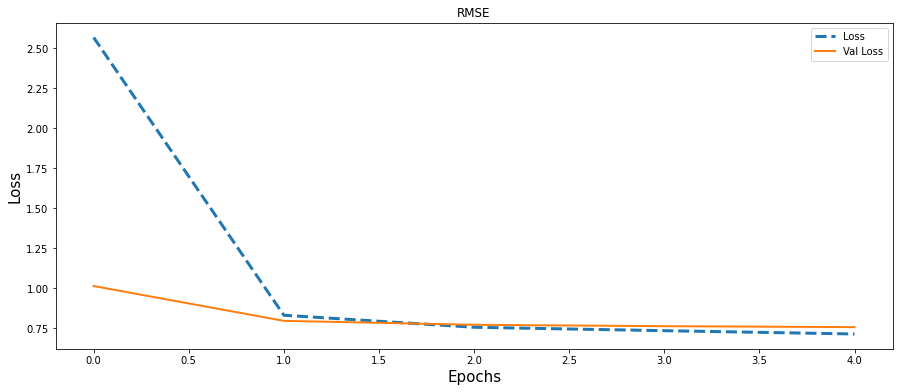

In [325]:
plt.figure(figsize=(15, 6))
plt.plot(history.history['loss'], lw =3, ls = '--', label = 'Loss')
plt.plot(history.history['val_loss'], lw =2, ls = '-', label = 'Val Loss')
plt.xlabel('Epochs', fontsize=15)
plt.ylabel('Loss', fontsize=15)
plt.title('RMSE')
plt.legend()

## The second improvement we can make is running the output of the dot product through a sigmoid layer and then scaling the result using the min and max ratings in the data. 

- This is a neat technique that introduces a non-linearity into the output and results in a modest performance bump.
- I also refactored the code a bit by pulling out the embedding layer and reshape operation into a separate class.

# Model 2 (Embedding + Dot Product + Normalize + Sigmoid)

In [0]:
from keras.layers import Add, Activation, Lambda

In [0]:
class EmbeddingLayer:
    def __init__(self, n_items, n_factors):
        self.n_items = n_items
        self.n_factors = n_factors
    
    def __call__(self, x):
        x = Embedding(self.n_items, self.n_factors, embeddings_initializer='he_normal',
                      embeddings_regularizer=l2(1e-6))(x)
        x = Reshape((self.n_factors,))(x)
        return x
def RecommenderV2(n_users, n_movies, n_factors, min_rating, max_rating):
    user = Input(shape=(1,))
    u = EmbeddingLayer(n_users, n_factors)(user)
    ub = EmbeddingLayer(n_users, 1)(user)
    
    movie = Input(shape=(1,))
    m = EmbeddingLayer(n_movies, n_factors)(movie)
    mb = EmbeddingLayer(n_movies, 1)(movie)
    x = Dot(axes=1)([u, m])
    x = Add()([x, ub, mb])
    x = Activation('sigmoid')(x)
    x = Lambda(lambda x: x * (max_rating - min_rating) + min_rating)(x)
    model = Model(inputs=[user, movie], outputs=x)
    opt = Adam(lr=0.001)
    model.compile(loss=root_mean_squared_error, optimizer=opt)
    return model

In [328]:
model2 = RecommenderV2(n_users, n_movies, n_factors, min_rating, max_rating)
model2.summary()

Model: "model_36"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_71 (InputLayer)           (None, 1)            0                                            
__________________________________________________________________________________________________
input_72 (InputLayer)           (None, 1)            0                                            
__________________________________________________________________________________________________
embedding_87 (Embedding)        (None, 1, 50)        47200       input_71[0][0]                   
__________________________________________________________________________________________________
embedding_89 (Embedding)        (None, 1, 50)        84100       input_72[0][0]                   
___________________________________________________________________________________________

In [329]:
history = model2.fit(x=X_train_array, y=y_train, batch_size=64, epochs=5,
                    verbose=1, validation_data=(X_test_array, y_test))

Train on 90002 samples, validate on 10001 samples
Epoch 1/5
90002/90002 [==============================] - 8s 85us/step - loss: 0.9398 - val_loss: 0.8483
Epoch 2/5
90002/90002 [==============================] - 5s 60us/step - loss: 0.7509 - val_loss: 0.7570
Epoch 3/5
90002/90002 [==============================] - 5s 59us/step - loss: 0.6748 - val_loss: 0.7382
Epoch 4/5
90002/90002 [==============================] - 5s 60us/step - loss: 0.6196 - val_loss: 0.7340
Epoch 5/5
90002/90002 [==============================] - 5s 60us/step - loss: 0.5697 - val_loss: 0.7347


In [330]:
# EVALUATE MODEL IN THE TEST SET
score_rmse_test = model2.evaluate(X_test_array, y_test)
print('Test Score:', score_rmse_test)

# EVALUATE MODEL IN THE TRAIN SET
score_rmse_train = model2.evaluate(X_train_array, y_train)
print('Train Score:', score_rmse_train)

10001/10001 [==============================] - 1s 53us/step
Test Score: 0.7346740534288646
90002/90002 [==============================] - 4s 48us/step
Train Score: 0.5202489207419858


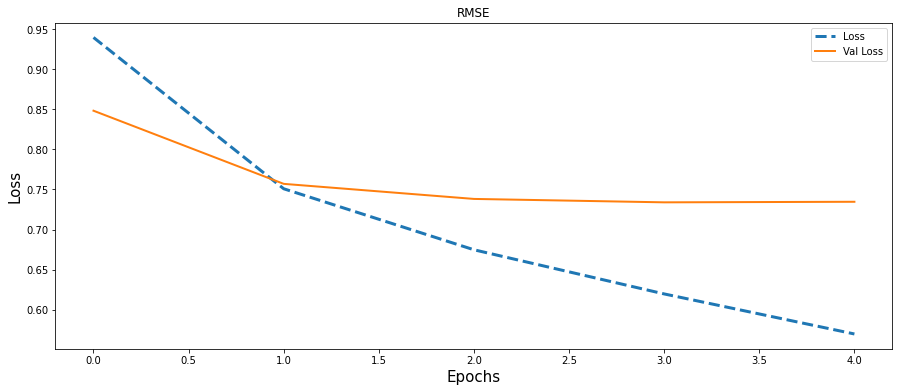

In [331]:
plt.figure(figsize=(15, 6))
plt.plot(history.history['loss'], lw =3, ls = '--', label = 'Loss')
plt.plot(history.history['val_loss'], lw =2, ls = '-', label = 'Val Loss')
plt.xlabel('Epochs', fontsize=15)
plt.ylabel('Loss', fontsize=15)
plt.title('RMSE')
plt.legend()

- Those two additions to the model resulted in a pretty sizable improvement. Validation error is now down to ~0.76 which is about as good as what Jeremy got (and I believe close to SOTA for this data set).

- That pretty much covers the conventional approach to solving this problem, but there’s another way we can tackle this. 

- Instead of taking the dot product of the embedding vectors, what if we just concatenated the embeddings together and stuck a fully-connected layer on top of them? 

- It’s still not technically “deep” but it would at least be a neural network! To modify the code, we can remove the bias embeddings from V2 and do a concat on the embedding layers instead. 
- Then we can add some dropout, insert a dense layer, and stick some dropout on the dense layer as well. 
- - Finally, we’ll run it through a single-unit dense layer to keep the sigmoid trick at the end.

# Model 3 (Embedding + Dot Product + Normalize + Dense + Dropout + Sigmoid)

In [0]:
from keras.layers import Concatenate, Dense, Dropout

In [0]:
from keras import backend as K

def root_mean_squared_error(y_true, y_pred):
        return K.sqrt(K.mean(K.square(y_pred - y_true), axis=-1)) 

In [0]:
def RecommenderNet(n_users, n_movies, n_factors, min_rating, max_rating):
    user = Input(shape=(1,))
    u = EmbeddingLayer(n_users, n_factors)(user)
    
    movie = Input(shape=(1,))
    m = EmbeddingLayer(n_movies, n_factors)(movie)
    
    x = Concatenate()([u, m])
    x = Dropout(0.05)(x)
    
    x = Dense(10)(x) 
    x = Activation('relu')(x)
    x = Dropout(0.5)(x)
    
    x = Dense(1)(x)
    x = Activation('sigmoid')(x)
    x = Lambda(lambda x: x * (max_rating - min_rating) + min_rating)(x)
    model = Model(inputs=[user, movie], outputs=x)
    opt = Adam(lr=0.001)
    model.compile(loss=root_mean_squared_error, optimizer=opt)
    return model

In [335]:
model3 = RecommenderNet(n_users, n_movies, n_factors, min_rating, max_rating)
model3.summary()

Model: "model_37"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_73 (InputLayer)           (None, 1)            0                                            
__________________________________________________________________________________________________
input_74 (InputLayer)           (None, 1)            0                                            
__________________________________________________________________________________________________
embedding_91 (Embedding)        (None, 1, 50)        47200       input_73[0][0]                   
__________________________________________________________________________________________________
embedding_92 (Embedding)        (None, 1, 50)        84100       input_74[0][0]                   
___________________________________________________________________________________________

In [336]:
history3 = model3.fit(x=X_train_array, y=y_train, batch_size=64, epochs=5,
                    verbose=1, validation_data=(X_test_array, y_test))

Train on 90002 samples, validate on 10001 samples
Epoch 1/5
90002/90002 [==============================] - 8s 90us/step - loss: 0.8212 - val_loss: 0.7575
Epoch 2/5
90002/90002 [==============================] - 6s 63us/step - loss: 0.7637 - val_loss: 0.7484
Epoch 3/5
90002/90002 [==============================] - 6s 63us/step - loss: 0.7525 - val_loss: 0.7430
Epoch 4/5
90002/90002 [==============================] - 6s 64us/step - loss: 0.7485 - val_loss: 0.7430
Epoch 5/5
90002/90002 [==============================] - 6s 63us/step - loss: nan - val_loss: nan


In [337]:
# EVALUATE MODEL IN THE TEST SET
score_rmse_test = model3.evaluate(X_test_array, y_test)
print('Test Score:', score_rmse_test)

# EVALUATE MODEL IN THE TRAIN SET
score_rmse_train = model3.evaluate(X_train_array, y_train)
print('Train Score:', score_rmse_train)

10001/10001 [==============================] - 0s 46us/step
Test Score: nan
90002/90002 [==============================] - 4s 45us/step
Train Score: nan


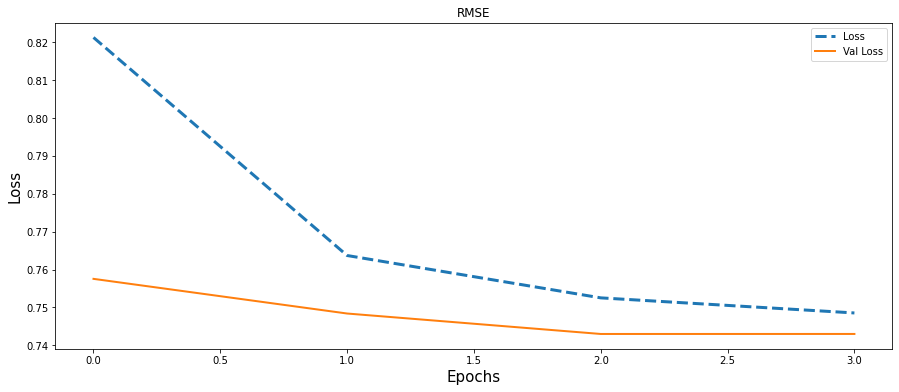

In [338]:
plt.figure(figsize=(15, 6))
plt.plot(history3.history['loss'], lw =3, ls = '--', label = 'Loss')
plt.plot(history3.history['val_loss'], lw =2, ls = '-', label = 'Val Loss')
plt.xlabel('Epochs', fontsize=15)
plt.ylabel('Loss', fontsize=15)
plt.title('RMSE')
plt.legend()

## Without doing any tuning at all we still managed to get a result that’s pretty close to the best performance we saw with the traditional approach. 
- This technique has the added benefit that we can easily incorporate additional features into the model. 
- For instance, we could create some date features from the timestamp or throw in the movie genres as a new embedding layer. 
- We could tune the size of the movie and user embeddings independently since they no longer need to match. Lots of possibilities here.

-- Reference: https://medium.com/@jdwittenauer/deep-learning-with-keras-recommender-systems-e7b99cb29929